# Create Ackley Function

In [1]:
import os

os.chdir("/Users/user_name/Desktop/DynaBO")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from deap.benchmarks import ackley
import seaborn as sns
from ConfigSpace import ConfigurationSpace, Configuration
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, NormalFloatHyperparameter

from smac import HyperparameterOptimizationFacade, Scenario, BlackBoxFacade
from smac.runhistory.dataclasses import TrialInfo, TrialValue
from smac.utils.configspace import convert_configurations_to_array
from dynabo.smac_additions.dynmaic_prior_acquisition_function import DynamicPriorAcquisitionFunction
from dynabo.smac_additions.local_and_prior_search import LocalAndPriorSearch
from smac.acquisition.function import EI
from smac.main.smbo import SMBO

In [3]:
def ackley_wrapper(trial_info: TrialInfo, x_values=None, seed=None) -> tuple[float]:
    """Wrapper for the Ackley function to handle input as a list or numpy array."""
    config: Configuration = trial_info.config
    x = np.array([config["x1"]])

    trial_value = TrialValue(cost=ackley(x), time=0.0)
    return trial_value

## Create Configuration Space

In [4]:
configuration_space = ConfigurationSpace()
configuration_space.add(UniformFloatHyperparameter("x1", lower=-5, upper=5, default_value=0))

## Create SMAC

In [5]:
def create_smac(
    acquisition_function: str,
):
    # Scenerio
    smac_scenario = Scenario(configspace=configuration_space, deterministic=True, seed=0, n_trials=50)

    # Initial design
    initial_design_size = 3
    initial_design = HyperparameterOptimizationFacade.get_initial_design(scenario=smac_scenario, n_configs=initial_design_size)

    intensifier = HyperparameterOptimizationFacade.get_intensifier(
        scenario=smac_scenario,
        max_config_calls=1,
    )
    if acquisition_function is None:
        acquisition_function = EI()

    surrogate_model = BlackBoxFacade.get_model(scenario=smac_scenario)
    surrogate_model = None

    local_and_prior_search = LocalAndPriorSearch(
        configspace=configuration_space,
        acquisition_function=acquisition_function,
        max_steps=500,  # TODO wie viele local search steps sind reasonable?
    )
    smac = HyperparameterOptimizationFacade(
        scenario=smac_scenario,
        target_function=ackley_wrapper,
        acquisition_function=acquisition_function,
        initial_design=initial_design,
        intensifier=intensifier,
        overwrite=True,
        acquisition_maximizer=local_and_prior_search,
        model=surrogate_model,
    )
    return smac

## Plot Layouts

In [6]:
def set_upper_layout(ax):
    ax.set_ylabel("Cost")
    ax.set_xlabel("Hyperparameter")
    ax.set_title("Function to be Optimized")
    # Set x and y limits
    ax.set_xlim(-5, 5)
    return ax


def set_lower_layout(ax):
    ax.set_ylabel("Acquisition Value")
    ax.set_xlabel("Hyperparameter")
    ax.set_title("Acquisition Function")
    # Set x and y limits
    ax.set_xlim(-5, 5)
    ax.set_yscale("log")
    return ax

In [7]:
def fit_surrogate_model(smac: HyperparameterOptimizationFacade, plotting_smac: HyperparameterOptimizationFacade):
    plotting_trials = plotting_smac._runhistory_encoder._get_considered_trials()
    plotting_configs = [plotting_smac.runhistory.get_config(trial_info.config_id) for trial_info in plotting_trials]
    plotting_configs_array = convert_configurations_to_array(plotting_configs).squeeze()

    plott_configs_values = [config["x1"] for config in plotting_configs]

    # Find x values of the configurations in plotting_trials
    past_configs = []
    past_configs_position = []
    past_configs_costs = []
    for trial_key, trial_value in smac._runhistory_encoder._get_considered_trials().items():
        config = smac.runhistory.get_config(trial_key.config_id)
        past_configs.append(config["x1"])
        array_config = convert_configurations_to_array([config])[0]
        past_configs_position.append(np.argmin(np.abs(plotting_configs_array - array_config)))
        past_configs_costs.append(trial_value.cost)

    # Normalize all configs
    plotting_trials_vectors_normalized, _ = plotting_smac._runhistory_encoder._build_matrix(plotting_trials, store_statistics=True)

    past_configs_normalized = list()
    for past_config_position in past_configs_position:
        past_configs_normalized.append(plotting_trials_vectors_normalized[past_config_position])

    # Predict mean and std for all x_values
    past_configs_normalized = np.vstack(past_configs_normalized)
    past_configs_costs = np.array(past_configs_costs)
    model = smac._model
    model = model.train(past_configs_normalized, past_configs_costs)
    return model, plott_configs_values, plotting_trials_vectors_normalized, past_configs, past_configs_costs, plotting_configs


def plot_smac_model_belief(ax, smac: HyperparameterOptimizationFacade, plotting_smac: HyperparameterOptimizationFacade):
    model, plotting_configs_array, plotting_trials_vectors_normalized, past_configs, past_configs_costs, _ = fit_surrogate_model(smac, plotting_smac)

    means, stds = model.predict(plotting_trials_vectors_normalized)
    means = means.flatten()
    stds = stds.flatten()
    ax.plot(plotting_configs_array, means, label="Model Mean", color="green")
    ax.fill_between(plotting_configs_array, means - stds, means + stds, color="green", alpha=0.2)

    ax.scatter(past_configs, past_configs_costs, color="red", s=100, label="Evaluated Points", zorder=5)


def plot_acquisition_function(ax, smac: HyperparameterOptimizationFacade, plotting_smac: HyperparameterOptimizationFacade, pibo: bool, dynabo: bool):
    acquisition_function = smac._acquisition_function
    model = smac._model
    if isinstance(acquisition_function, DynamicPriorAcquisitionFunction):
        acquisition_function._acquisition_function.update(model=model, eta=0, num_data=smac.runhistory.finished)
    acquisition_function.update(model=model, eta=0, num_data=smac.runhistory.finished)
    model, plotting_configs_array, _, _, _, plotting_configs = fit_surrogate_model(smac, plotting_smac)

    # Compute acquisition function values for all x_values

    acquisition_function_values = acquisition_function(plotting_configs)
    color = "orange" if pibo else "red"
    label = "PIBO Acquisition Function" if pibo else "Acquisition Function"

    ax.plot(plotting_configs_array, acquisition_function_values, label=label, color=color)
    ax.legend()


def plot_ackley_function(ax, x_values):
    y_values = [ackley([x]) for x in x_values]
    ax.plot(x_values, y_values, label="Ackley Function", color="blue")
    return ax


def create_plots(x_values, base_optimizer: HyperparameterOptimizationFacade, pibo_optimizer: HyperparameterOptimizationFacade, plotting_smac: HyperparameterOptimizationFacade = None):
    # Plot ackley function
    fix, axs = plt.subplots(2, 1, figsize=(15, 10))
    sns.set_style("whitegrid")

    plot_ackley_function(axs[0], x_values)
    if base_optimizer is not None:
        plot_smac_model_belief(axs[0], base_optimizer, x_values, plotting_smac)

        plot_acquisition_function(axs[1], base_optimizer, x_values, plotting_smac, pibo=False, dynabo=False)

    if pibo_optimizer is not None:
        plot_acquisition_function(axs[1], pibo_optimizer, x_values, plotting_smac, pibo=True, dynabo=False)

    set_upper_layout(axs[0])
    set_lower_layout(axs[1])

In [8]:
def create_base_optimizer() -> HyperparameterOptimizationFacade:
    base_optimizer = create_smac(acquisition_function=None)
    return base_optimizer


def create_prior_optimizer() -> HyperparameterOptimizationFacade:
    acquisition_function = DynamicPriorAcquisitionFunction(EI(), initial_design_size=3, discretize=False)
    return create_smac(acquisition_function)


base_optimizer = create_base_optimizer()
pibo_optimizer = create_prior_optimizer()
dynabo_optimizer = create_prior_optimizer()

[WARNING][target_function_runner.py:74] The argument x_values is not set by SMAC: Consider removing it from the target function.


[INFO][abstract_initial_design.py:139] Using 3 initial design configurations and 0 additional configurations.
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[WARNING][target_function_runner.py:74] The argument x_values is not set by SMAC: Consider removing it from the target function.
[INFO][abstract_initial_design.py:139] Using 3 initial design configurations and 0 additional configurations.
[WARNING][prior_acquisition_function.py:110] Discretizing the prior for random forest models.
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[WARNING][target_function_runner.py:74] The argument x_values is not set by SMAC: Consider removing it from the target function.
[INFO][abstract_initial_design.py:139] Using 3 initial design configurations and 0 additional configurations.
[WARNING][prior_acquisition_function.py:110] Discretizing the prior for random forest models.


In [9]:
x_values = np.linspace(-5, 5, 1000)

In [10]:
plotting_smac = create_base_optimizer()
# create configs for each x in x_values
configs = [Configuration(configuration_space, values={"x1": x}) for x in x_values]
# create TrialInfos, and TrialValues
trial_infos = [TrialInfo(config=config, instance=None, seed=0) for config in configs]
trial_values = [TrialValue(cost=-100, time=0.0) for trial_info in trial_infos]
# Tell the smac object about these trials
for ti, tv in zip(trial_infos, trial_values):
    plotting_smac.tell(ti, tv)

[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[WARNING][target_function_runner.py:74] The argument x_values is not set by SMAC: Consider removing it from the target function.
[INFO][abstract_initial_design.py:139] Using 3 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config abb45a as new incumbent because there are no incumbents yet.


## Initial Design

In [11]:
for _ in range(3):
    info: TrialInfo = base_optimizer.ask()
    trial_value = ackley_wrapper(info, x_values)
    base_optimizer.tell(info, trial_value)
for _ in range(3):
    info: TrialInfo = pibo_optimizer.ask()
    trial_value = ackley_wrapper(info, x_values)
    pibo_optimizer.tell(info, trial_value)
    pibo_optimizer._acquisition_function.current_config_nuber = pibo_optimizer.runhistory.finished
for _ in range(3):
    info: TrialInfo = dynabo_optimizer.ask()
    trial_value = ackley_wrapper(info, x_values)
    dynabo_optimizer.tell(info, trial_value)
    pibo_optimizer._acquisition_function.current_config_nuber = pibo_optimizer.runhistory.finished

[INFO][abstract_intensifier.py:307] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:517] Added config 09be20 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:596] Added config 6b7192 and rejected config 09be20 as incumbent because it is not better than the incumbents on 1 instances: 
[INFO][abstract_intensifier.py:307] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:517] Added config 09be20 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:596] Added config 6b7192 and rejected config 09be20 as incumbent because it is not better than the incumbents on 1 instances: 
[INFO][abstract_intensifier.py:307] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:517] Added config 09be20 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:596] Added config 6b7192 and rejected config 09be20 as incumbent becaus

In [12]:
def set_prior(smbo: SMBO, prior_configspace: ConfigurationSpace):
    smbo.intensifier.config_selector._acquisition_maximizer.dynamic_init(prior_configspace)
    smbo.intensifier.config_selector._acquisition_function.dynamic_init(
        acquisition_function=smbo.intensifier.config_selector._acquisition_function._acquisition_function,
        prior_configspace=prior_configspace,
        decay_beta=50 / 10,
        prior_start=smbo.runhistory.finished,
    )

In [13]:
# Create priro configspace for the center which is x = 0
new_configspace = ConfigurationSpace()
new_configspace.add(NormalFloatHyperparameter("x1", lower=-5, upper=5, default_value=0, mu=0, sigma=10))

set_prior(pibo_optimizer, new_configspace)

## Plot with Optimizer

TypeError: plot_smac_model_belief() takes 3 positional arguments but 4 were given

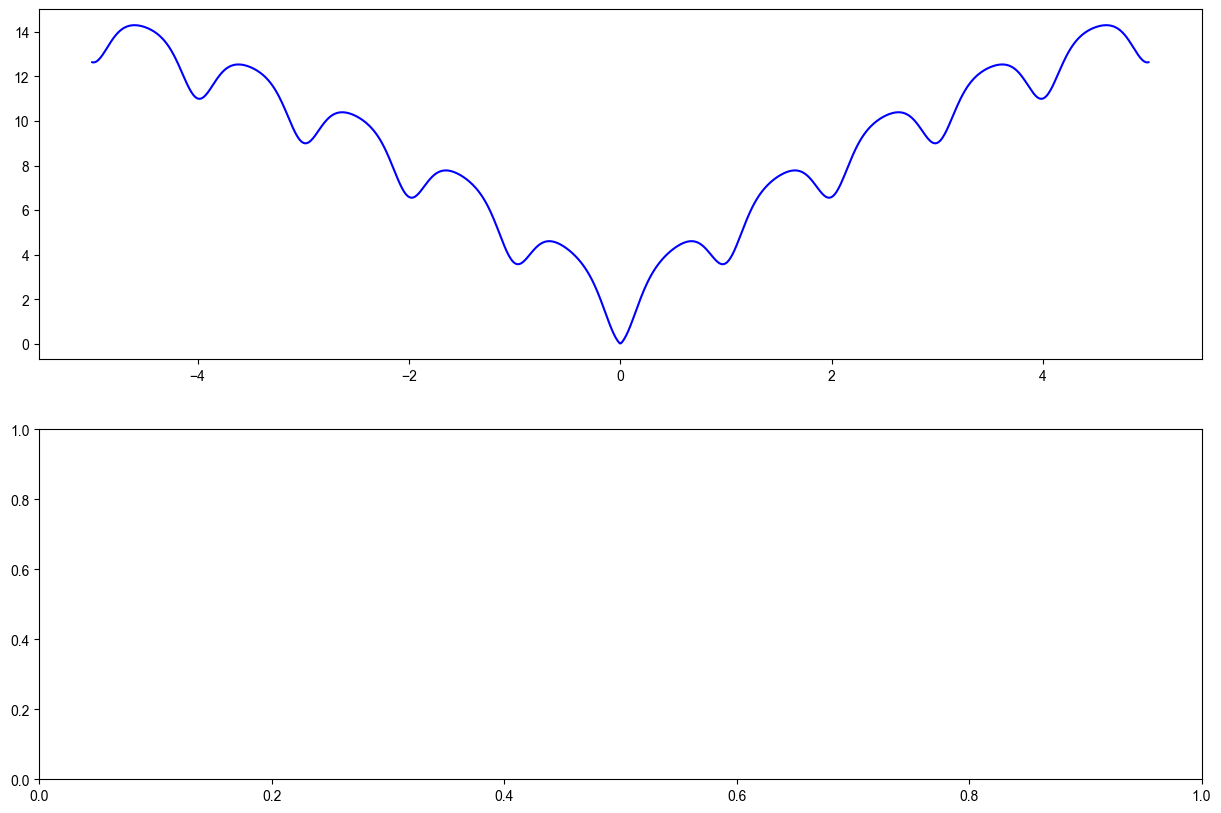

In [14]:
control_optimizer = pibo_optimizer
create_plots(x_values, base_optimizer, pibo_optimizer, plotting_smac)
for trial_key in range(5):
    info: TrialInfo = control_optimizer.ask()
    trial_value = ackley_wrapper(info, x_values)
    base_optimizer.tell(info, trial_value)
    pibo_optimizer.tell(info, trial_value)
    print(info)

    create_plots(x_values, base_optimizer, pibo_optimizer, plotting_smac)

# TODOS
1. Plot pibo acquisition function
2. Plot dynabo acquisition function